In [1]:
# Created on 11/11/22 at 2:57 PM


"""
this script uses xgb as a classifier to predict various output


"""

# %%

import jupyter_black


jupyter_black.load()
import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import interactive


interactive(True)
import pandas as pd
import numpy as np
import os
import hdf5storage
import random
from sklearn.metrics import r2_score
import pickle
import matplotlib
from matplotlib.gridspec import GridSpec
from scipy.io import savemat
import shutil
import os
from configparser import ConfigParser
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import time

from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import timeop

plt.rcParams.update({"font.size": 18})
colors = sns.color_palette("deep")
sns.set(style="whitegrid")
# local pacakges

In [2]:
# load data


def loadsubjdict(fnames):
    datadict = hdf5storage.loadmat(fnames)
    return datadict


masktrial = []
respall = []
sequenceall = np.empty((0, 30))
rtall = []
sidall = []
Count = []

for cond in [100, 250, 50, 500]:
    print(cond)

    projectdir = "/home/jenny/evidence-chain/"
    filename = "/ssd/rwchain-all/round2/rwchain-beh/combined/all_" + str(cond) + ".mat"
    datadict = hdf5storage.loadmat(filename)

    masktrial.extend(datadict["masktrial"])
    respall.extend(datadict["resp"])
    sequenceall = np.vstack((sequenceall, datadict["sequence"]))
    rtall.extend(datadict["rt"])
    rtadjusted = datadict["rt"] - 300
    count = np.zeros_like(datadict["rt"])
    val, m = divmod(rtadjusted, cond)
    count[m == 0] = val[m == 0]  # it's exacly at the onset of the new stimulus,
    # we say they made a decisiona after seeing th previous ones
    count[m > 0] = val[m > 0] + 1  # count is the last display that would count
    # count =3 means they have seen display 0, 1, 2.

    count[count >= 30] = 30
    Count.extend(count)
    sidall.extend(datadict["sidall"])

100
250
50
500


In [4]:
np.unique(sidall)

array([0., 1., 2., 3.])

In [10]:
masktrial = np.array(masktrial)
respall = np.array(respall)
# sequenceall = np.array(sequenceall)
rtall = np.array(rtall)
sidall = np.array(sidall)

In [11]:
sequenceall.shape

(4234, 30)

In [80]:
cumsum = np.cumsum(sequenceall, axis=1)


# calculate first occurence of max evidene
maxval = []
maxind = []
sequence_stopAll = []
bound = []
boundind = []
nummax = []
binary_seq_all = np.zeros_like(cumsum)
binary_seq_all.fill(np.nan)
for c in range(cumsum.shape[0]):
    binary_seq_all[c, : int(Count[c])] = sequenceall[c, : int(Count[c])]
    sequence_stop = cumsum[
        c, : int(Count[c])
    ]  # for example, if rt adjusted i 708, for 250ms, one have seen 3 stimulus.
    sequence_stopAll.append(sequence_stop)
    bound.append(sequence_stop[-1])
    boundind.append(len(sequence_stop) - 1)
    maxindtrial = np.where(np.abs(sequence_stop) == np.max(abs(sequence_stop)))[0]
    maxind.append(maxindtrial)
    maxval.append(sequence_stop[maxindtrial])
    nummax.append(len(maxindtrial))

In [13]:
nancount = np.isnan(binary_seq_all).sum(axis=1)

Text(0, 0.5, 'Number of Trials')

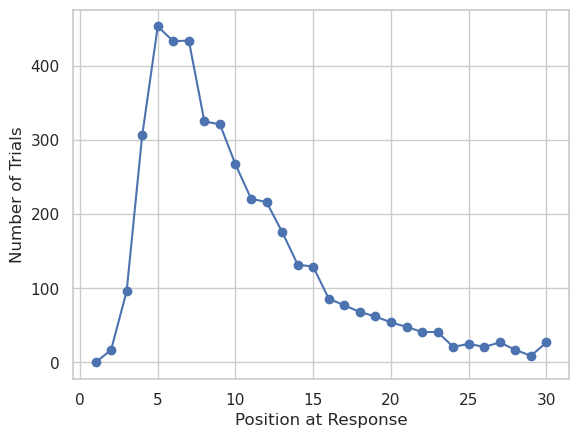

In [25]:
nTrials = []
for t in range(0, 30):
    threshold = t

    dataset = binary_seq_all[nancount == 30 - threshold, :]
    dataset_resp = respall[nancount == 30 - threshold]
    dataset_resp[dataset_resp == -1] = 0
    dataset = dataset[:, 0:threshold]
    nTrials.append(dataset.shape[0])
plt.plot(np.arange(1, 31), np.array(nTrials), "o-")
plt.xlabel("Position at Response")
plt.ylabel("Number of Trials")

In [53]:
threshold = 5

dataset = binary_seq_all[nancount == 30 - threshold, :]
dataset_resp = respall[nancount == 30 - threshold]
dataset_resp[dataset_resp == -1] = 0
dataset = dataset[:, 0:threshold]
dataset.shape

(433, 5)

In [54]:
dataset[0, :]

array([-1., -1., -1., -1., -1.])

In [55]:
binary_seq_all.shape

(4234, 30)

In [56]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [57]:
# model_type="truth"
# if model_type ==  "truth":
#     dataset_resp = dataset.sum(axis=1) >0

In [58]:
model_type = "continue"
if model_type == "continue":
    dataset = binary_seq_all[nancount <= 30 - threshold, :]
    dataset_resp = np.isnan(
        dataset[:, threshold]
    )  # True means they stopped, false means they kept going
    dataset = dataset[:, :threshold]

In [59]:
dataset.shape

(3362, 5)

In [60]:
# train test val split
x_train, x_test, y_train, y_test = train_test_split(
    dataset, dataset_resp, test_size=0.2, random_state=1
)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.25, random_state=1
)

In [61]:
# A parameter grid for XGBoost

from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# create a dictionary containing the hyperparameters
# to tune and the range of values to try
PARAMETERS = {
    "subsample": [0.75, 1],
    "gamma": [0.5, 1.5, 5],
    "colsample_bytree": [0.75, 1],
    "max_depth": [3, 4, 5],
    "min_child_weight": [1, 5],
    #               "tree_method":['gpu_hist'],
    "learning_rate": [0.1, 0.01, 0.05],
}


# create a validation set which will be used for early stopping
eval_set = [(x_val, y_val)]

# initialise an XGBoost classifier, set the number of estimators,
# evaluation metric & early stopping rounds
estimator = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=100,
    seed=42
    #                             tree_method = 'gpu_hist',
    #                              gpu_id =1
)

# initialise GridSearchCV model by passing the XGB classifier we
# initialised in the last step along with the dictionary of parameters
# and values to try. We also set the number of folds to validate over
# along with the scoring metic to use
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=PARAMETERS,
    cv=7,
    n_jobs=10,
    verbose=2,
    scoring="roc_auc",
    return_train_score=True,
)

In [ ]:
# fit model
clf = grid_search.fit(
    x_train,
    y_train,
    eval_set=eval_set,
    eval_metric=["auc"],
    early_stopping_rounds=10,
    verbose=1,
)

# print out the best hyperparameters

In [82]:
print(clf.best_score_, clf.best_params_)

0.6747736086744265 {'colsample_bytree': 0.75, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.75}
[CV] END colsample_bytree=1, gamma=5, learning_rate=0.05, max_depth=5, min_child_weight=5, subsample=1; total time=   0.0s


In [67]:
mymodel = clf.best_estimator_

In [68]:
eval_set = [(x_train, y_train), (x_val, y_val)]

In [69]:
mymodel.fit(
    x_train,
    y_train,
    early_stopping_rounds=15,
    eval_metric=["auc", "logloss"],
    eval_set=eval_set,
    verbose=False,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [70]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob_train = mymodel.predict_proba(x_train)
y_pred_prob_val = mymodel.predict_proba(x_val)

y_pred_prob_test = mymodel.predict_proba(x_test)

fpr_train, tpr_train, _ = metrics.roc_curve(y_train, y_pred_prob_train[:, 1])
fpr_val, tpr_val, _ = metrics.roc_curve(y_val, y_pred_prob_val[:, 1])
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_pred_prob_test[:, 1])

In [71]:
auc_train = metrics.auc(fpr_train, tpr_train)
auc_val = metrics.auc(fpr_val, tpr_val)
auc_test = metrics.auc(fpr_test, tpr_test)

In [72]:
print(auc_train)

print(auc_val)
print(auc_test)

0.7153595092292411
0.6978749582916249
0.6461802802008988


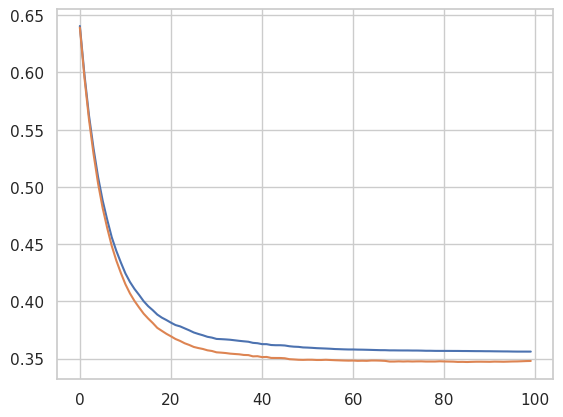

In [73]:
results = mymodel.evals_result()
plt.plot(results["validation_0"]["logloss"])
plt.plot(results["validation_1"]["logloss"])

In [74]:
x_train.shape

(2016, 5)

In [75]:
booster: xgb.Booster = mymodel.get_booster()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

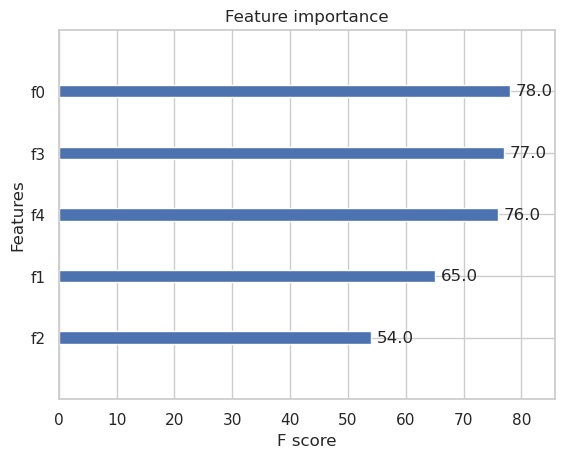

In [76]:
xgb.plot_importance(booster, grid=True, importance_type="weight")

In [77]:
scores = mymodel.predict_proba(x_test)

fpr, tpr, thresh = metrics.roc_curve(y_test, scores[:, 1])

roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.6461802802008988


In [78]:
fpr

array([0.        , 0.03092784, 0.04639175, 0.06357388, 0.08934708,
       0.12371134, 0.14261168, 0.1838488 , 0.22164948, 0.24570447,
       0.26975945, 0.29725086, 0.32989691, 0.36597938, 0.40549828,
       0.43986254, 0.47938144, 0.51202749, 0.54467354, 0.57731959,
       0.60652921, 0.63745704, 0.66838488, 0.69931271, 0.71305842,
       0.79553265, 0.82302405, 0.85223368, 0.87628866, 0.91580756,
       0.95704467, 1.        ])

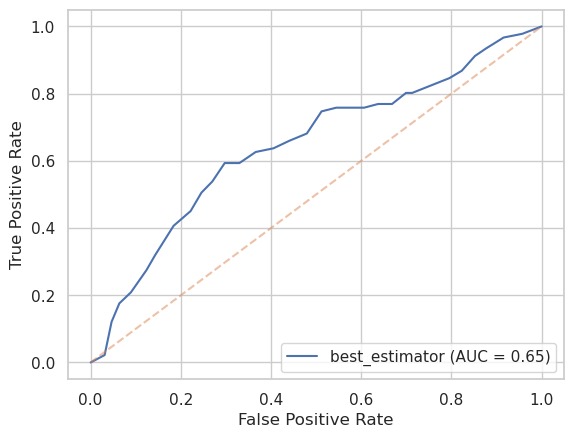

In [79]:
display = metrics.RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="best_estimator"
)
display.plot()
plt.plot(np.linspace(0, 1), np.linspace(0, 1), "--", alpha=0.5)
plt.show()

In [144]:
from sklearn.inspection import PartialDependenceDisplay

In [145]:
PartialDependenceDisplay.from_estimator(mymodel, x_train, features, target=0)


NameError: name 'mc_clf' is not defined